# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
# <center><span style='background:yellow'>Modèle sur mesure simple</span></center>
===============================================================================================

### Sommaire <a class="anchor" id="sommaire"></a>
* [Import des librairies et chargement des données](#00)
* [Séparation des données d'entraînement, de validation et de test](#10)
* [Application de la régression logistique](#20)
* [Optimisation des hyperparamètres du modèle de régression](#30)
* [Sauvegarde du modèle final](#40)

## Import des librairies et chargement des données<a class="anchor" id="00"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import gensim
from gensim.models import KeyedVectors
from tqdm import tqdm

### Lecture des données d'entraînement, de validation et de test<a class="anchor" id="10"></a>

In [ ]:
path = '/content/drive/MyDrive/p7/'

# Chargement des données
train = pd.read_csv(path + 'data/train.csv', index_col=0, encoding='utf-8')
validation = pd.read_csv(path + 'data/validation.csv', index_col=0, encoding='utf-8')

train.dropna(inplace=True)
validation.dropna(inplace=True)

In [ ]:
train.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
1273151,#Goodsex When he makes you squirt all over him,1,goodsex make squirt,goodsex make squirt
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0,look quot;sexy sailors&quot outfit laura hen n...,look quot;sexi sailors&quot outfit laura hen n...
499993,i dont know why twitter just now sent that thr...,0,not know twitter send word headache,nt know twitter sent word headach
122529,A particularly brutal rejection has put me off...,0,particularly brutal rejection writing never co...,particular brutal reject write never consid eg...
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1,dear sa friday pa dito thursday ang game,dear sa friday pa dito thursday ang game


In [ ]:
train.isna().sum()

tweet               0
label               0
tweet_clean_lemm    0
tweet_clean_stem    0
dtype: int64

In [ ]:
train.shape, validation.shape

((625617, 4), (268092, 4))

## Vectorisation avec Word Embedding<a class="anchor" id="20"></a>

In [ ]:
seed = 0
w2v_size = 100
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen  =  25 

In [ ]:
# Création et entraînement du modèle Word2Vec
def w2v_vectors(serie, vector_size=100, min_count=1, window=4, epochs=100, random_state=0):
    sentences = serie.to_list()
    sentences =  [gensim.utils.simple_preprocess(text) for text in sentences]
    
    print("Build & train Word2Vec model ...")
    model  =  gensim.models.Word2Vec(min_count = min_count,
                                       window = window,
                                       vector_size = vector_size,
                                       seed = random_state,
                                       workers = 4)

    model.build_vocab(sentences)
    model.train(sentences, 
                total_examples = model.corpus_count, 
                epochs = epochs)
    model_vectors  =  model.wv
    words  =  model_vectors.index_to_key
    print("Vocabulary size:", len(words))
    print("Word2Vec trained")
    return model_vectors



# Vectoriser un token avec word2vec
def word_vector(token, model_vectors, size=100):

    vec = np.zeros(size).reshape((1, size))
    count = 0
    
    for word in token:
        try:
            vec += model_vectors[word].reshape((1, size))
            count += 1.
            
        except KeyError: 
            continue
    if count != 0:
        vec /= count
    return vec


# Vectorisation du corpus avec word2vec
def model_vectorisation(serie, model_vectors, size=100):
    print('Tokenisation ...')
    sentences = serie.to_list()
    sentences =  [gensim.utils.simple_preprocess(text) for text in sentences]

    vectors = np.zeros((len(sentences), size)) 
    print('Vectorisation du corpus ...')
    for i in range(len(sentences)):
        vectors[i,:] = word_vector(model_vectors = model_vectors, 
                                   token = sentences[i], 
                                   size = size)
        
    vectors_df = pd.DataFrame(vectors)
    print('matrix created')

    return vectors_df

In [ ]:
lemm_w2v_vectors = w2v_vectors(train.tweet_clean_lemm)
lemm_w2v_vectors.save(path + "embedding/word2vec.wordvectors")

Build & train Word2Vec model ...
Vocabulary size: 141428
Word2Vec trained


In [ ]:
# Load w2v KeyVectors
# lemm_w2v_vectors = KeyedVectors.load(path + "embedding/word2vec.wordvectors", mmap='r')

In [ ]:
lemm_w2v_xtrain = model_vectorisation(train.tweet_clean_lemm, 
                               model_vectors = lemm_w2v_vectors)

Tokenisation ...
Vectorisation du corpus ...
matrix created


In [ ]:
lemm_w2v_xval = model_vectorisation(validation.tweet_clean_lemm,
                                    model_vectors = lemm_w2v_vectors)

Tokenisation ...
Vectorisation du corpus ...
matrix created


In [ ]:
ytrain, yval = train.label, validation.label

## Application de la régression logistique <a class="anchor" id="20"></a>

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.metrics import classification_report, accuracy_score
from time import time

def learning_model(model, xtrain, ytrain, xtest, ytest, threshold=0.5, RocCurve=True, LearningCurve=True):
    pd.options.display.float_format = '{:.2f}'.format
    
    ## definition du metrique de validation
    beta = 1
    f1_scorer = make_scorer(fbeta_score, beta=beta)    
    print(str(model),'\n')
    t0 = time()
    model.fit(xtrain, ytrain)
    print('Learning time :', round(time()-t0, 2))
    crossval = cross_validate(model, 
                                xtrain, 
                                ytrain, 
                                cv=4, 
                                scoring = 'accuracy',
                                return_train_score=True)
   
    print('Accuracy train  mean : ', round(crossval['train_score'].mean(),2))
    print('Accuracy validation mean : ', round(crossval['test_score'].mean(),2))
    print('\n')
        
    yprob_train = model.predict_proba(xtrain)[:,1]
    
    yprob_test = model.predict_proba(xtest)[:,1]
    
    ypred = (yprob_test>threshold)*1 
    
    confusion_m = pd.DataFrame(confusion_matrix(ytest, ypred)).T
    
    confusion_m['total'] = confusion_m.sum(axis=1)
    
    confusion_m.loc['total',:] = confusion_m.sum(axis=0)
    
    print("confusion_matrix :")
    
    display(confusion_m.astype('int64').rename_axis(index = ['Actual'], columns=['predicted']))
    print("Classification report")
    print(classification_report(ytest, ypred))
    

#   learning curve
    if LearningCurve == True:
        N, train_score, test_score = learning_curve(model, 
                                                    xtrain, 
                                                    ytrain,
                                                    cv=4, 
                                                    train_sizes=np.linspace(0.2,1,4),)
            
        plt.plot(N, train_score.mean(axis=1), label = 'Train score')
        plt.plot(N, test_score.mean(axis=1), 'r', label='Validation score')
        plt.title('Learning Curve')
        plt.xlabel('Nombre de tweets')
        plt.ylabel('Accuracy score')
        plt.legend()
        plt.show()
        
#   roc curve
    if RocCurve == True :
        fpr_test, tpr_test, thld_test = roc_curve(ytest, yprob_test)
        plt.plot(fpr_test, tpr_test, label='test')
        plt.legend()
        plt.title('Courbe ROC')
        plt.xlabel('Taux de faux positif')
        plt.ylabel('Taux de vrai positif')
        plt.show() 

In [ ]:
lr = LogisticRegression()
lr.fit(lemm_w2v_xtrain, ytrain)

LogisticRegression()

In [ ]:
lemm_w2v_xtrain.shape, ytrain.shape, lemm_w2v_xval.shape

((625617, 100), (625617,), (268092, 100))

LogisticRegression() 

Learning time : 10.53
Accuracy train  mean :  0.74
Accuracy validation mean :  0.74


confusion_matrix :


predicted,0,1,total
Actual,,,
0,99483,34111,133594
1,34770,99728,134498
total,134253,133839,268092


Classification report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    134253
           1       0.74      0.75      0.74    133839

    accuracy                           0.74    268092
   macro avg       0.74      0.74      0.74    268092
weighted avg       0.74      0.74      0.74    268092



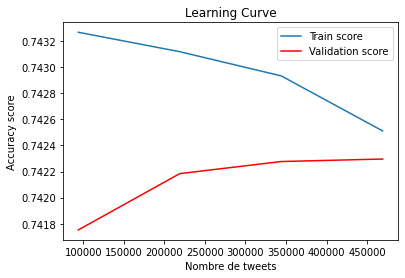

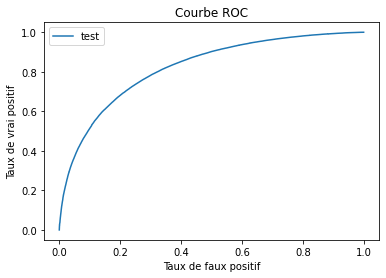

In [ ]:
learning_model(lr, lemm_w2v_xtrain, ytrain, lemm_w2v_xval, yval)

## Optimisation des hyperparamètres du modèle de régression <a class="anchor" id="30"></a>

In [ ]:
from sklearn.model_selection import GridSearchCV
lr_log = LogisticRegression(random_state=seed)

params = {'C' : np.logspace(-2,2,10), 'penalty' : ['l2']}

lr_grid = GridSearchCV(lr_log, param_grid=params, 
                    cv = 4, 
                    scoring = 'accuracy')
lr_grid.fit(lemm_w2v_xtrain, ytrain)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'penalty': ['l2']},
             scoring='accuracy')

LogisticRegression(C=0.01, random_state=0) 

Learning time : 10.5
Accuracy train  mean :  0.74
Accuracy validation mean :  0.74


confusion_matrix :


predicted,0,1,total
Actual,,,
0,99472,34125,133597
1,34781,99714,134495
total,134253,133839,268092


Classification report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    134253
           1       0.74      0.75      0.74    133839

    accuracy                           0.74    268092
   macro avg       0.74      0.74      0.74    268092
weighted avg       0.74      0.74      0.74    268092



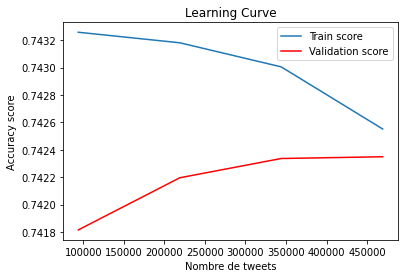

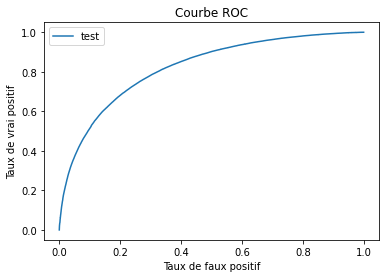

In [ ]:
learning_model(lr_grid.best_estimator_, lemm_w2v_xtrain, ytrain, lemm_w2v_xval, yval)

## Sauvegarde du modèle final <a class="anchor" id="40"></a>

In [ ]:
#Sauvegarde du modèle
dump(lr_grid.best_estimator_, path + 'models/best_regression_model_saved.joblib')

['/content/drive/MyDrive/p7/models/best_regression_model_saved.joblib']

In [ ]:
# Chargement du modèle
best_estimator_ = load(path + 'models/best_regression_model_saved.joblib')

<a href="##sommaire" rev="footnote">&#8617;</a>